In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
import numpy as np
import math
from scipy import stats
import scipy.special

In [73]:
# I worked mostly using dictionaries, but I want to switch to DataFrames now, because it's easier to plot them. 
# I might also want to convert to ndarrays to handling the data, so instead of changing the code, 
# I created this function to convert to different data types:

def convert(my_dict, to_type='DataFrame'):
    if to_type=='DataFrame':
        return pd.DataFrame.from_dict(my_dict, orient='index', columns=['P'])
    else:
        raise ValuError(f'Datatype{to_type} not supported')

# Open the files

In [347]:
temp = open('A.fna','r').read().split('\n')
A = ''.join(temp)

temp = open('B.fna','r').read().split('\n')
B = ''.join(temp)

#The string C will be used for testing the functions
C='HOOOOLA\nwey'

# Basic tests

## Make sure the files have a DNA structure

In [117]:
def isDNA(Z):
    ''' Checks whether the sequence Z contains only vald nucleotides (A,T,G or C)
    Returns a boolean and a message pointing out letters which are not valid nucleotides'''
    nonNuc=[]
    for N in Z:
        if N!='A' and N!='T' and N!='G' and N!='C':# and N!='\n':
            nonNuc.append(N)
    if len(nonNuc)==0: # If I didn't find any character not corresponding to a nucleotide, consider it as a valid DNA sequence
        toPrint='All letters are valid nucleotides'
        return(True, toPrint)
    else:
        toPrint = f'The sequence contains the letters: {nonNuc}, which are not a valid nucleotides'
        return(False, toPrint)

print(f'is A a valid DNA sequence? -> {isDNA(A)}')
print(f'is B a valid DNA sequence? -> {isDNA(B)}')
print(f'is C a valid DNA sequence? -> {isDNA(C)}')

# Check if one file is bigger than the other
print('')
print(f'A contains {len(A)} nucleotides')
print(f'B contains {len(B)} nucleotides')

# Define N as the number of nucleotides in the sequences
N = len(A)

is A a valid DNA sequence? -> (True, 'All letters are valid nucleotides')
is B a valid DNA sequence? -> (True, 'All letters are valid nucleotides')
is C a valid DNA sequence? -> (False, "The sequence contains the letters: ['H', 'O', 'O', 'O', 'O', 'L', '\\n', 'w', 'e', 'y'], which are not a valid nucleotides")

A contains 981133 nucleotides
B contains 981133 nucleotides


So both files contain a valid sequence of nucleotides and they are the same length

## Probability of finding a given nucleotide

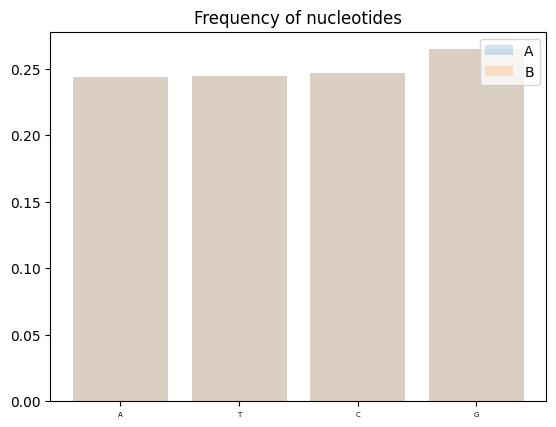

Probabilities in file A: {'A': 0.24399750084850882, 'T': 0.24446736579036685, 'C': 0.24694715191518377, 'G': 0.26458798144594053}
Probabilities in file B; {'A': 0.24399750084850882, 'T': 0.24446736579036685, 'C': 0.24694715191518377, 'G': 0.26458798144594053}


In [354]:
def probNuc(Z, N):
    ''' Returns the empirical probability of finding a nucleotide N in the sequence'''
    num_N = Z.count(N)/len(Z)
    return num_N

A_single_probs = {}
B_single_probs = {}

for nuc in ['A', 'T', 'C', 'G']:
    A_single_probs[nuc] = probNuc(A,nuc)
    B_single_probs[nuc] = probNuc(B,nuc)

plt.bar(A_single_probs.keys(), A_single_probs.values(), alpha=0.2, label='A')
plt.bar(B_single_probs.keys(), B_single_probs.values(), alpha=0.2,label='B')
plt.title('Frequency of nucleotides')
plt.legend(loc='best')
plt.show()

print(f'Probabilities in file A: {A_single_probs}')
print(f'Probabilities in file B; {B_single_probs}')

So exactly the same number of nucleotides appear in each sequence (that is, one is a permutation of the other), and each nucleotide appears roughly with the same probability, except for G which is more common. 

# A bit more advanced

## Probability distribution of n-tuples

Now I compute the probability distribution of n-tuples and compare them for both files. If one of the files is a random permutations, I'd expect it to have probabilities similar to independently and identically distributed (iid) smapling.

That is, $p(N_1, N_2, ..., N_n) \approx p(N_1) p(N_2) \cdots p(N_n)$

To compute this probabilities, I will consider that:

- If we consider sequential (non-overlapping) n-tuples, we can create $\DeclarePairedDelimiter\floor{\lfloor}{\rfloor} \floor{N/n}$ n-tuples of length n <br>
- If we allow the starting point to change (which makes sens, because we don't know where the transcription starting point is, and we'd also like to account for alternative splicing et. al.), any of the N letters can be the starting point, except for the last n-1, so we can have $N-(n-1)$ n-tuples

In [355]:
# Define funtions that give probability of an ntuple to appear

# Overlapping
def prob_ntuple(Z, ntuple):
    ''' Return probability of finding an n-letter word to appear, considering overlapping subchains'''
    N = len(Z)
    n = len(ntuple)
    normalization = (N-n+1)
    
    results=0
    for i in range(N-n+1):
        if Z[i:i+n] == ntuple:
            results += 1
    return results/normalization

# Non-overlapping
def prob_ntuple_no_overlap(Z, ntuple):
    ''' Return probability of finding an n-letter word to appear, considering non-overlapping subchains'''
    N=len(Z)
    n=len(ntuple)
    normalization = N//n

    results=0
    for i in range(0,N-n,n):
        if Z[i:i+n] == ntuple:
            results += 1
    return results/normalization

In [356]:
# Compute probabilities for each codon

# Initialize containers
A_codons, B_codons, random_codons = ({}, {}, {})
A_codons_no_overlap, B_codons_no_overlap = ({}, {})
for i in itertools.product(['A','T', 'C', 'G'],  repeat=3):
    codon= ''.join(i)
    # Filling probabilities for file A
    A_codons[codon] = prob_ntuple(A,codon)
    A_codons_no_overlap[codon] = prob_ntuple_no_overlap(A,codon)
    # Filling probabilities for file A
    B_codons_no_overlap[codon] = prob_ntuple_no_overlap(B,codon)
    B_codons[codon] = prob_ntuple(B,codon)
    # Filling probabilities as sampled iid from single-nucleotide probabilities
    random_codons[codon] = A_single_probs[i[0]]*A_single_probs[i[1]]*A_single_probs[i[2]]
    
    #print(codon, A_codons[codon], B_codons[codon])

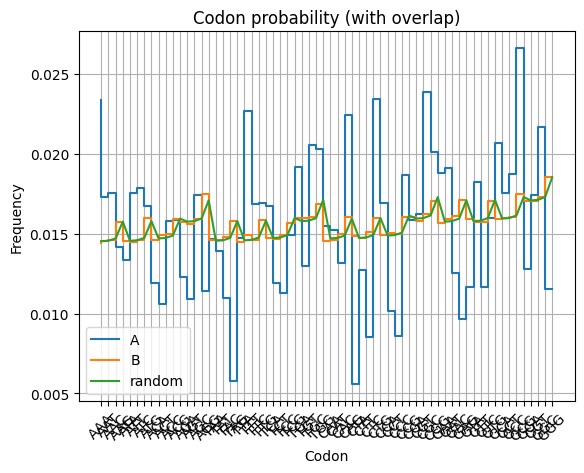

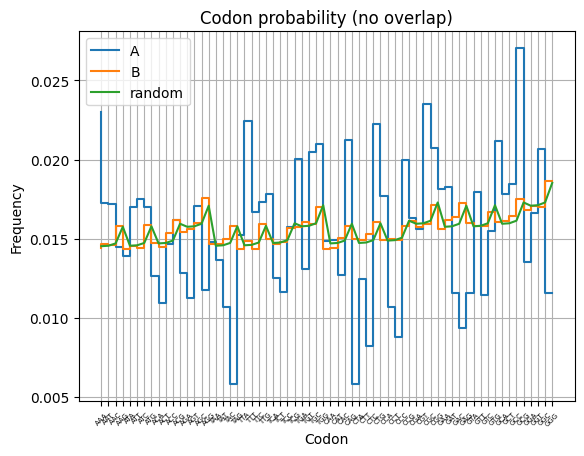

In [108]:
plt.step(A_codons.keys(), A_codons.values(), label='A')
plt.step(B_codons.keys(), B_codons.values(), label='B')
#plt.plot(B_codons_no_overlap.keys(), [4**(-3)]*len(B_codons_no_overlap.keys()), ':', label='random')
plt.plot(random_codons.keys(), random_codons.values(), label='random')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('Codon probability (with overlap)')
plt.xlabel('Codon')
plt.ylabel('Frequency')
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=5)    # fontsize of the tick labels
plt.grid()
plt.show()

plt.step(A_codons_no_overlap.keys(), A_codons_no_overlap.values(), label='A')
plt.step(B_codons_no_overlap.keys(), B_codons_no_overlap.values(), label='B')
#plt.plot(B_codons_no_overlap.keys(), [4**(-3)]*len(B_codons_no_overlap.keys()), ':', label='random')
plt.plot(random_codons.keys(), random_codons.values(), label='random')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('Codon probability (no overlap)')
plt.xlabel('Codon')
plt.ylabel('Frequency')
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=5)    # fontsize of the tick labels
plt.grid()
plt.show()


(I don't really see the use of this, but I wanted to check we're not missing anything)

In [109]:
def big_differences(Z_codons, Z_codons_no_overlap, tol):
    for k in Z_codons.keys():
        dif = Z_codons[k] - Z_codons_no_overlap[k]
        if np.abs(dif) > tol:
            if dif>0:
                whichIsGreater='prob. with overlap is greater'
            else:
                whichIsGreater='prob. with no overlap is greater'
            print(f'{k}, difference is {np.abs(dif)}, {whichIsGreater}')
    # If the max difference is greater than tol, then say it
    if max([np.abs(Z_codons[k]-Z_codons_no_overlap[k]) for k in Z_codons.keys()]) < tol:
        print(f'None (all differences are less than {tol})')

tol=1e-3
print(f'Codons whose probability differ by more than {tol} when counted with or with no overlap')
print('-> In file A:')
big_differences(A_codons, A_codons_no_overlap,tol)
print('-> In file B:')
big_differences(B_codons, B_codons_no_overlap,tol)

Codons whose probability differ by more than 0.001 when counted with or with no overlap
-> In file A:
ACC, difference is 0.0010905930932899564, prob. with overlap is greater
TCA, difference is 0.0010416368499511289, prob. with no overlap is greater
CAG, difference is 0.001173157551631835, prob. with overlap is greater
CTG, difference is 0.001133408548969917, prob. with overlap is greater
CCG, difference is 0.0012566925839809853, prob. with no overlap is greater
-> In file B:
None (all differences are less than 0.001)


### Testing a null hypothesis

Null hypothesis: the file can be regarded as a sequential series of codons (triplets) sampled from a multinomial distribution with equal probability $p=\frac{1}{4^3}=0.016$ for each codon. 
Thus, we can compute the probability of obtaining the observed $x_i$ counts (no overlap) for each codon i, given that the the probability for each codon is 0.016. 

Recall the multinomial distribution for n trials and k categories is:
$$ p(x_1, x_2, ..., x_k; n) = n! \frac{\prod_{i}^{k} p_i^{x_i}}{\prod_i^k x_i!} $$

We will compute the log of this probability

In [110]:
N=len(A)
n=N//3
p=4**(-3)

def log_prob(A_codons_no_overlap):
    sum_log_xi_fact = 0                            # \sum_i log(x_i)!
    sum_xi_log_pi = 0                              # \sum_i (x_i \log(p_i))
    for k in A_codons_no_overlap.keys():
        x = A_codons_no_overlap[k]*n 
        sum_log_xi_fact += x*math.log(x)-x #Using Stirling
        sum_xi_log_pi += x*math.log(p)
    
    #print(p_product)
    log_nfact = n*math.log(n)-n            # log(n!), using Stirling
    return (log_nfact+sum_xi_log_pi-sum_log_xi_fact)

A_logprob = log_prob(A_codons_no_overlap)
B_logprob = log_prob(B_codons_no_overlap)

print(f'A has a prob to occur of e^{A_logprob}, while B has a prob to occur of e^{B_logprob}')
print(f'Number of sites is {n}, sample space is 64^{n}, or approximately e^{n*3}')

A has a prob to occur of e^-12894.193335101008, while B has a prob to occur of e^-594.5553037771024
Number of sites is 327044, sample space is 64^327044, or approximately e^981132


That is not yet the p-value. Based on its definition, we will define our p-value as the probability to observe a deviation from the null hypothesis at least as extreme as that observed in the data. Looking at our data, the value that deviates the most from the multinomial distribution is that of the codon GCG. What is the probability of obtaining at least those many times the codon GCG given that the probability of this codon is $p=4^{-3}$?

In [111]:
def bigger_deviations(Z_codons_no_overlap):
    #Z_deviations = [np.abs(Z_codons_no_overlap[k]-random_codons[k]) for k in random_codons.keys()]
    Z_deviations = [(Z_codons_no_overlap[k]-random_codons[k]) for k in random_codons.keys()]
    max_deviation = max(Z_deviations)
    max_codon_index = Z_deviations.index(max_deviation)
    max_codon = list(Z_codons_no_overlap.keys())[max_codon_index]
    max_prob = Z_codons_no_overlap[max_codon]
    return max_codon, math.floor(max_prob*n)


A_max_deviation = max(A_codons_no_overlap, key=A_codons_no_overlap.get)
print(f'In A, max deviation occurs in codon {A_max_deviation}, having probability {A_codons_no_overlap[A_max_deviation]}')

B_max_deviation = max(B_codons_no_overlap, key=B_codons_no_overlap.get)
print(f'In B, max deviation occurs in codon {B_max_deviation}, having probability {B_codons_no_overlap[B_max_deviation]}')
A_ntimes_max = A_codons_no_overlap[A_max_deviation]*n
B_ntimes_max = B_codons_no_overlap[B_max_deviation]*n

def prob_binomial_ntimes(num_times, p):
    zeroone = n*math.log(n)-n
    zerotwo = A_ntimes_max*math.log(A_ntimes_max)-A_ntimes_max
    zerothree = (n-A_ntimes_max)*math.log(n-A_ntimes_max)-(n-A_ntimes_max)
    zero = math.log(math.comb(n,int(A_ntimes_max)))
    first = zeroone-zerotwo-zerothree
    second = (p**(num_times))
    third = (1-p)**(n*num_times)
    prob = first*second 
    return prob

#prob_binomial_ntimes(A_ntimes_max,p)

A_p_value=1-scipy.special.betainc(n-A_ntimes_max, 1+A_ntimes_max, 1-B_single_probs['G']*B_single_probs['C']*B_single_probs['G'])
B_p_value=1-scipy.special.betainc(n-B_ntimes_max, 1+B_ntimes_max, 1-B_single_probs['G']**3)
print(f'p-value for A: {A_p_value}')
print(f'p-value for B: {B_p_value}')

A_md_codon, A_md_n = bigger_deviations(A_codons_no_overlap)
B_md_codon, B_md_n = bigger_deviations(B_codons_no_overlap)
A_md_prob = A_single_probs[A_md_codon[0]]*A_single_probs[A_md_codon[1]]*A_single_probs[A_md_codon[2]]
B_md_prob = B_single_probs[B_md_codon[0]]*B_single_probs[B_md_codon[1]]*B_single_probs[B_md_codon[2]]
print(A_md_codon, A_md_n, math.floor(A_md_prob*n))
print(B_md_codon, B_md_n, math.floor(B_md_prob*n))

A_p_value=1-scipy.special.betainc(n-A_md_n, 1+A_md_n, 1-A_md_prob)
B_p_value=1-scipy.special.betainc(n-B_md_n, 1+B_md_n, 1-B_md_prob)
print(f'p-value for A: {A_p_value}')
print(f'p-value for B: {B_p_value}')

In A, max deviation occurs in codon GCG, having probability 0.02702388669414513
In B, max deviation occurs in codon GGG, having probability 0.0186549822042294
p-value for A: 1.1102230246251565e-16
p-value for B: 0.2850637865742507
GCG 8838 5653
AGG 5746 5586
p-value for A: 1.1102230246251565e-16
p-value for B: 0.015669413161821577


## Conditional probabilities

Another expected feature of a non-random nucleotide sequence would be that the appearance of a nucleotide in a codon is not independent of the rest of the nucleotides in the codon. 
Thus for example, the sequence AAA would not be equally likely as the sequence AAG. 

We will test the following null hypothesis: the sampling process of nucleotides in the sequences is at most (in terms of its memory capacity) Markovian. 

We already took a step by proving a less strict null hypothesis: The sampling process of nucleotides in the sequences is iid. This is, $p(N1 N2 N3) = p(N1) p(N2) p(N3)$

We will now attempt to falsify a Markovianity null hypothesis, that is, that: $$p(N1 N2 N3) = p(N2 N1) p(N3|N2 N1) = p(N1) p(N2|N1) p(N3|N2 N1) =  p(N1) p(N2|N1) p(N3|N2)$$

In [112]:
def probN2_givenN1(Z,N1,N2):
    num_N1=0
    num_N1_N2=0
    for i in range(len(Z)-1):
        if Z[i] == N1:
            num_N1 += 1
            if Z[i+1] == N2:
                num_N1_N2 += 1
    return num_N1_N2/num_N1


def probN3_givenN1N2(Z,N1,N2,N3):
    num_N1N2=0
    num_N1N2_N3=0
    for i in range(len(Z)-2):
        if Z[i] == N1 and Z[i+1]==N2:
            num_N1N2 += 1
            if Z[i+2] == N3:
                num_N1N2_N3 += 1
    return num_N1N2_N3/num_N1N2

In [113]:
A_simple_conditionals, B_simple_conditionals,iid_duplets = ({}, {},{})
# Iterate over all possible duplets (4^2 of them)
for i in itertools.product(['A','T', 'C', 'G'], ['A','T', 'C', 'G']):#, ['A','T', 'C', 'G']):
    duplet= ''.join(i)
    A_simple_conditionals[duplet]=probN2_givenN1(A,i[0],i[1])
    B_simple_conditionals[duplet]=probN2_givenN1(B,i[0],i[1])
    iid_duplets[duplet] = B_single_probs[i[0]]*B_single_probs[i[1]]

# A_simple_conditionals
# B_simple_conditionals


A_double_conditionals, B_double_conditionals = ({}, {})
# Iterate over all possible triplets (4^3 of them)
for i in itertools.product(['A','T', 'C', 'G'], ['A','T', 'C', 'G'], ['A','T', 'C', 'G']):
    triplet= ''.join(i)
    A_double_conditionals[triplet]=probN3_givenN1N2(A,i[0],i[1],i[2])
    B_double_conditionals[triplet]=probN3_givenN1N2(B,i[0],i[1],i[2])



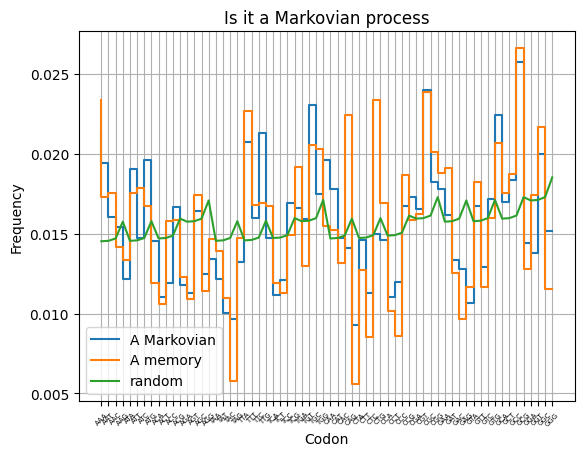

In [114]:
A_Markovian, A_memory = ({},{})
B_Markovian, B_memory = ({},{})
for i in itertools.product(['A','T', 'C', 'G'], ['A','T', 'C', 'G'], ['A','T', 'C', 'G']):
    triplet= ''.join(i)
    N1N2 = i[0]+i[1]
    N2N3 = i[1]+i[2]
    N1N2N3 = i[0]+i[1]+i[2]
    A_Markovian[triplet] = A_single_probs[i[0]]*A_simple_conditionals[N1N2]*A_simple_conditionals[N2N3]
    A_memory[triplet] = A_single_probs[i[0]]*A_simple_conditionals[N1N2]*A_double_conditionals[N1N2N3]
    B_Markovian[triplet] = B_single_probs[i[0]]*B_simple_conditionals[N1N2]*B_simple_conditionals[N2N3]
    B_memory[triplet] = B_single_probs[i[0]]*B_simple_conditionals[N1N2]*B_double_conditionals[N1N2N3]

plt.step(A_Markovian.keys(), A_Markovian.values(), label='A Markovian')
plt.step(A_memory.keys(), A_memory.values(), label='A memory')
plt.plot(random_codons.keys(), random_codons.values(), label='random')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('Is it a Markovian process')
plt.xlabel('Codon')
plt.ylabel('Frequency')
plt.rc('xtick', labelsize=5)    # fontsize of the tick labels
plt.grid()
plt.show()

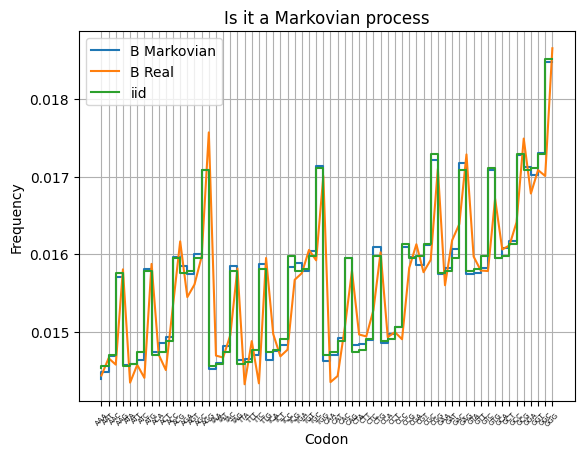

In [115]:
plt.step(B_Markovian.keys(), B_Markovian.values(), label='B Markovian')
#plt.step(B_memory.keys(), B_memory.values(), label='B memory')
plt.plot(B_codons_no_overlap.keys(), B_codons_no_overlap.values(), label='B Real')
plt.step(random_codons.keys(), random_codons.values(), label='iid')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('Is it a Markovian process')
plt.xlabel('Codon')
plt.ylabel('Frequency')
plt.rc('xtick', labelsize=5)    # fontsize of the tick labels
plt.grid()
plt.show()

In [ ]:
B_N2_N1, iid_N2_N1, B_real = ({},{},{})
A_N2_N1, A_real = ({},{})
for i in itertools.product(['A','T', 'C', 'G'], ['A','T', 'C', 'G']):#, ['A','T', 'C', 'G']):
    N1N2 = i[0]+i[1]
    N1 = i[0]
    N2 = i[1]
    B_N2_N1[N1N2] = B_simple_conditionals[N1N2]*B_single_probs[N1]
    A_N2_N1[N1N2] = A_simple_conditionals[N1N2]*A_single_probs[N1]
    iid_N2_N1[N1N2] = B_single_probs[N2]*B_single_probs[N1]
    B_real[N1N2] = prob_ntuple(B,N1N2)
    A_real[N1N2] = prob_ntuple(A,N1N2)

In [ ]:
plt.step(B_N2_N1.keys(), B_N2_N1.values(), label='B Markovian')
plt.step(iid_N2_N1.keys(), iid_N2_N1.values(), label = 'iid')
plt.plot(B_real.keys(), B_real.values(), label = 'B Real')
plt.title('Duples probabilities for B')
plt.legend(loc='best')
plt.show()

plt.step(A_N2_N1.keys(), A_N2_N1.values(), label='A Markovian')
plt.step(iid_N2_N1.keys(), iid_N2_N1.values(), label = 'iid')
plt.plot(A_real.keys(), A_real.values(), label = 'A Real')
plt.title('Duples probabilities for A')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.step(random_codons.keys(), random_codons.values(), label = 'A iid')
plt.step(A_Markovian.keys(), A_Markovian.values(), label='A Markovian')
plt.plot(A_codons.keys(), A_codons.values(), label = 'A Real')
plt.title('Codons probabilities for A')
plt.legend(loc='best')
plt.show()

plt.step(random_codons.keys(), random_codons.values(), label = 'B iid')
plt.step(B_Markovian.keys(), B_Markovian.values(), label='B Markovian')
#plt.step(B_memory.keys(), B_memory.values(), label = 'B with memory')
plt.plot(B_codons_no_overlap.keys(), B_codons_no_overlap.values(), label = 'B Real')
plt.title('Codons probabilities for B')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid()
plt.show()



In [ ]:
def deviation_from_real(Z_compare, Z_real):
    Z_deviations = [np.abs(Z_compare[k]-Z_real[k]) for k in random_codons.keys()]
    max_deviation = max(Z_deviations)
    max_codon_index = Z_deviations.index(max_deviation)
    max_codon = list(Z_compare.keys())[max_codon_index]
    max_prob = Z_real[max_codon]
    return max_codon, math.floor(max_prob*n)

B_md_Mark_codon, B_md_Mark_n = deviation_from_real(B_Markovian, B_codons_no_overlap)
B_Mark_prob = B_Markovian[B_md_Mark_codon]
print('Comparing Markovian from real')
print(B_md_Mark_codon, B_md_Mark_n, math.floor(B_Mark_prob*n))

B_md_iid_codon, B_md_iid_n = deviation_from_real(random_codons, B_codons_no_overlap)
B_iid_prob=random_codons[B_md_iid_codon]
print('Comparing iid from real')
print(B_md_iid_codon, B_md_iid_n, math.floor(B_iid_prob*n))

# A_p_value=1-scipy.special.betainc(n-A_md_n, 1+A_md_n, 1-A_md_prob)
B_p_value_Mark=1-scipy.special.betainc(n-B_md_Mark_n, 1+B_md_Mark_n, 1-B_Mark_prob)
B_p_value_iid=1-scipy.special.betainc(n-B_md_iid_n, 1+B_md_iid_n, 1-B_iid_prob)
# print(f'p-value for A: {A_p_value}')
print(f'p-value for B Markovian: {B_p_value_Mark}')
print(f'p-value for B iid: {B_p_value_iid}')

In [ ]:
print(B_Mark_prob,B_iid_prob)

In [ ]:
1-scipy.special.betainc(n-B_md_iid_n, 1+B_md_iid_n, 1-0.017090)

In [171]:
4**4

256

In [341]:
math.log(4**3)

4.1588830833596715

## Entropy of subchains (considering n-letter words)

4.157171253822911


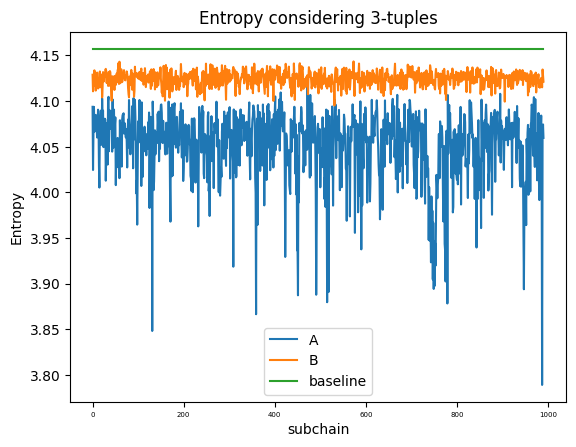

In [339]:
word_length=3

def entropy(chain,word_length=1):
    Shannon=0
    if(word_length==1):
        for nuc in ['A', 'T', 'C', 'G']:
            prob = probNuc(chain,nuc)
            Shannon -= prob * math.log(prob)
    elif(word_length==2):
        for i in itertools.product(['A','T', 'C', 'G'], repeat=word_length):
        #for i in itertools.product(['A','T', 'C', 'G'], ['A','T', 'C', 'G']):
            prob = prob_ntuple(chain,''.join(i))
            Shannon -= prob * math.log(prob)
    else:
        for i in itertools.product(['A','T', 'C', 'G'], repeat=word_length):
            if ''.join(i) in chain:
                prob = prob_ntuple(chain,''.join(i))
                Shannon -= prob * math.log(prob)
        
    return Shannon

baseline_entropy=np.sum([-random_codons[i]*math.log(random_codons[i]) for i in random_codons.keys()])
print(baseline_entropy)

sqrtN = math.floor(math.sqrt(N))
A_entropies, B_entropies = ([],[])
for i in range(0,N-sqrtN,sqrtN):
    A_subchain = A[i:i+sqrtN]
    B_subchain = B[i:i+sqrtN]
    A_entropies.append(entropy(A_subchain,word_length=word_length))
    B_entropies.append(entropy(B_subchain,word_length=word_length))

plt.plot(A_entropies,label='A')
plt.plot(B_entropies,label='B')
plt.plot([baseline_entropy]*sqrtN, label='baseline (iid distribution)')
plt.ylabel('Entropy')
plt.xlabel('subchain')
plt.title(f'Entropy considering {word_length}-tuples')
plt.legend(loc='best')



### Null hypothesis

Null hypothesis: -replace-toggle jp-DocumentSearch-button-contentåååååååååååååååååussian RV with mean value equal to the entropy of the whole chain

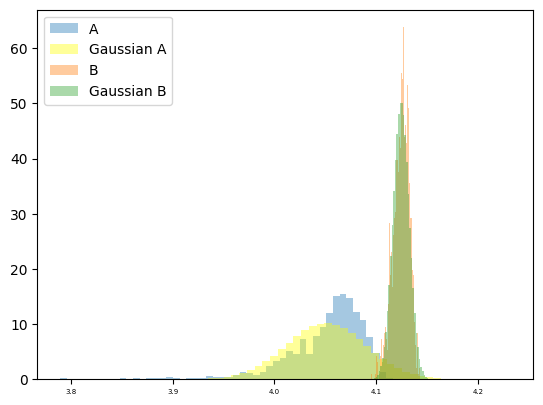

D_KL between Gaussian and A is 2.1487072984323965 and between Gaussian and B it's 0.6033483313232716, 
D_KL between A and B is 1.542869372252775 and between both Gaussians it's 0.09995021127167412


In [346]:
#mu = entropy(B,word_length=word_length)
def exponential(x):
    return 1/mu*math.exp(-x*mu)

gaussA=np.random.normal(np.mean(A_entropies), np.std(A_entropies), 1000000)
gaussB=np.random.normal(np.mean(B_entropies), np.std(B_entropies), 1000000)

A_entorpies_probs = plt.hist(A_entropies, alpha=0.4,label='A',bins=50,density=True)
gaussA_probs = plt.hist(gaussA, alpha=0.4, label='Gaussian A',bins=50, color='yellow',density=True)
B_entropies_probs = plt.hist(B_entropies, alpha=0.4, label='B',bins=50,density=True)
gaussB_probs = plt.hist(gaussB, alpha=0.4, label='Gaussian B',bins=50,density=True)
#plt.plot(A_entropies, [exponential(x) for x in A_entropies])
plt.legend(loc='best')
plt.show()


def DKL(a, b):
    
    a = np.asarray(a)/np.sum(a)
    b = np.asarray(b)/np.sum(b)
    relent = 0
    for i in range(len(b)):
        if (a[i]!=0 and b[i]!=0):
            relent+= a[i]*np.log(a[i]/b[i])
            #print(relent)
    return relent#np.sum(np.where(b != 0, a * np.log(a / b), 0))

DKL_A = DKL(gaussA_probs[0],A_entorpies_probs[0])
DKL_B = DKL(gaussB_probs[0], B_entropies_probs[0])#sum(scipy.special.rel_entr(B_entropies, gaussB))
DKL_AB = DKL(B_entorpies_probs[0],A_entorpies_probs[0])
DKL_gaussAB = DKL(gaussA_probs[0], gaussB_probs[0])

print(f"D_KL between Gaussian and A is {DKL_A} and between Gaussian and B it's {DKL_B}, \nD_KL between A and B is {DKL_AB} and \
between both Gaussians it's {DKL_gaussAB}")

We can interpret these results in the following way: 
The probability distribution for the entropy of subchains in file B is closer to being a Gaussian distribution than what A is. Thus, B is closer to satisfying the null hypothesis than A is. 

# First 

In [1]:
import matplotlib.pyplot as plt

#A=''
with open('A.fna') as f:
    # for line in f:
    #     A+=line.strip()
    A = f.read()
    # A = f.read().split('\n')
    # A = A.flatten()

temp = open('A.fna','r').read().split('\n')
AA = ''.join(temp)

with open('B.fna') as f:
    B = f.read()
    #A = A.flatten()

temp = open('B.fna','r').read().split('\n')
BB = ''.join(temp)

D='HOOOOLA\nwey'
def isDNA(C):
    nonNuc=[]
    for N in C:
        if N!='A' and N!='T' and N!='G' and N!='C' and N!='\n':
            nonNuc.append(N)
            print(N)
    if len(nonNuc)==0:
        return(True)
    else:
        return(False)

def countNuc(C, N):
    num_N = 0
    for nuc in C:
        if nuc==N:
            num_N+=1
    return num_N


def probN1_N2(C,N1,N2):
    num_N1=0
    num_N1_N2=0
    for i in range(len(C)-1):
        if C[i] == N1:
            num_N1 += 1
            if C[i+1] == N2:
                num_N1_N2 += 1
    return num_N1_N2/num_N1


def probN1N2_N3(C,N1,N2,N3):
    num_N1N2=0
    num_N1N2_N3=0
    for i in range(len(C)-2):
        if C[i] == N1 and C[i+1]==N2:
            num_N1N2 += 1
            if C[i+2] == N3:
                num_N1N2_N3 += 1
    return num_N1N2_N3/num_N1N2

def probN1N2N3_N4(C,N1,N2,N3,N4):
    num_N1N2N3=0
    num_N1N2N3_N4=0
    for i in range(len(C)-3):
        if C[i] == N1 and C[i+1]==N2 and C[i+2]==N3:
            num_N1N2N3 += 1
            if C[i+3] == N4:
                num_N1N2N3_N4 += 1
    return num_N1N2N3_N4/num_N1N2N3


A_A = countNuc(A,'A')/len(A)*100
T_A = countNuc(A,'T')/len(A)*100
G_A = countNuc(A,'G')/len(A)*100
C_A = countNuc(A,'C')/len(A)*100


A_B = countNuc(B,'A')/len(B)*100
T_B = countNuc(B,'T')/len(B)*100
G_B = countNuc(B,'G')/len(B)*100
C_B = countNuc(B,'C')/len(B)*100

A_C = countNuc(D,'A')
T_C = countNuc(D,'T')
G_C = countNuc(D,'G')
C_C = countNuc(D,'C')


print(A_A, T_A, G_A, C_A)
print(A_B, T_B, G_B, C_B)
print(A_C, T_C, G_C, C_C)

print(A[0:10], B[-10:-1])

len(AA)
AA[20000]=='T'

print(A[0:10])

AA_A = probN1_N2(AA,'C','A')
AA_T = probN1_N2(AA,'C','T')
AA_C = probN1_N2(AA,'C','C')
AA_G = probN1_N2(AA,'C','G')

BA_A = probN1_N2(BB,'C','A')
BA_T = probN1_N2(BB,'C','T')
BA_C = probN1_N2(BB,'C','C')
BA_G = probN1_N2(BB,'C','G')

print(AA_A, AA_T, AA_C, AA_G)
print(BA_A, BA_T, BA_C, BA_G)

ATT_A = probN1N2_N3(AA,'T','T', 'A')
ATT_T = probN1N2_N3(AA,'T','T', 'T')
ATT_C = probN1N2_N3(AA,'T','T', 'C')
ATT_G = probN1N2_N3(AA,'T','T', 'G')

BTT_A = probN1N2_N3(BB,'T','T', 'A')
BTT_T = probN1N2_N3(BB,'T','T', 'T')
BTT_C = probN1N2_N3(BB,'T','T', 'C')
BTT_G = probN1N2_N3(BB,'T','T', 'G')

print(ATT_A,ATT_T,ATT_C,ATT_G)
print(BTT_A,BTT_T,BTT_C,BTT_G)

probN1N2_N3(D,'O', 'O', 'L')
print('TTTT')
print(probN1N2N3_N4(AA,'T', 'T', 'T', 'T'))
print(probN1N2N3_N4(BB,'T', 'T', 'T', 'T'))

print('AAAA')
print(probN1N2N3_N4(AA,'A', 'A', 'A', 'A'))
print(probN1N2N3_N4(BB,'A', 'A', 'A', 'A'))

print('CCCC')
print(probN1N2N3_N4(AA,'C', 'C', 'C', 'C'))
print(probN1N2N3_N4(BB,'C', 'C', 'C', 'C'))

print('GGGG')
print(probN1N2N3_N4(AA,'G', 'G', 'G', 'G'))
print(probN1N2N3_N4(BB,'G', 'G', 'G', 'G'))

23.999735334631264 24.045951522126625 26.025026917671024 24.289864719905843
23.999735334631264 24.045951522126625 26.025026917671024 24.289864719905843
1 0 0 0
TGGTCCCACC ACATGGCGT
TGGTCCCACC
0.26833466095993597 0.20336625572152034 0.22013562428029568 0.30816345903824804
0.24367694644390148 0.24557964075810607 0.24690038301525458 0.2638430297827379
0.20663783969531227 0.3189628017525271 0.2363763924286246 0.238022966123536
0.24200143105386895 0.2490033731984054 0.24372210296773314 0.2652730927799925
TTTT
0.3251784351573372
0.24507389162561577
AAAA
0.3208115183246073
0.23987274655355248
CCCC
0.160156713759943
0.243145792230764
GGGG
0.20541780640607077
0.26496759310117546
